In [1]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
import urllib3, shutil

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

<class 'numpy.ndarray'>
(512, 512, 3)


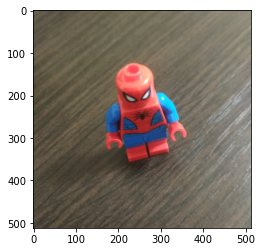

In [4]:
img = mpimg.imread("TrainData/SPIDER-MAN/001.jpg")
imgplot = plt.imshow(img)
print(type(img))
print(img.shape)

In [5]:
url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
filename = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

c = urllib3.PoolManager()

with c.request('GET', url, preload_content=False) as res, open(filename, 'wb') as out_file:
    shutil.copyfileobj(res, out_file)

In [6]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [7]:
# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(512, 512, 3),
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(local_weights_file)

2022-05-26 15:49:49.922463: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-26 15:49:49.922641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [8]:
# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  # Your Code Here
  layer.trainable = False  
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 255, 255, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 255, 255, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 30, 30, 768)


In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

from tensorflow.keras.optimizers import Adam

In [21]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense('1024', activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(37, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = Adam(0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 255, 255, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 255, 255, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [22]:
train_dir = "TrainData"
validation_dir = "TestData"

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1./255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    target_size=(512,512))      

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size=16,
                                                          class_mode='categorical',
                                                          target_size=(512,512))

Found 408 images belonging to 37 classes.
Found 86 images belonging to 37 classes.


In [ ]:
callbacks = myCallback()
history = model.fit(train_generator,
                              epochs=10,
                              validation_data=validation_generator,
                              callbacks=[callbacks])

Epoch 1/10


2022-05-26 15:56:03.917035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - ETA: 0s - loss: 6.3040 - accuracy: 0.0539

2022-05-26 15:57:37.389067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 103s 4s/step - loss: 6.3040 - accuracy: 0.0539 - val_loss: 4.1070 - val_accuracy: 0.1744
Epoch 2/10
26/26 [==============================] - 80s 3s/step - loss: 3.3289 - accuracy: 0.1593 - val_loss: 3.3453 - val_accuracy: 0.2674
Epoch 3/10
26/26 [==============================] - 84s 3s/step - loss: 2.8095 - accuracy: 0.2549 - val_loss: 2.9378 - val_accuracy: 0.2209
Epoch 4/10
26/26 [==============================] - 84s 3s/step - loss: 2.5254 - accuracy: 0.3309 - val_loss: 2.6054 - val_accuracy: 0.3140
Epoch 5/10
26/26 [==============================] - 82s 3s/step - loss: 2.1298 - accuracy: 0.3922 - val_loss: 2.5882 - val_accuracy: 0.3256
Epoch 6/10
26/26 [==============================] - 85s 3s/step - loss: 1.9611 - accuracy: 0.4363 - val_loss: 2.2899 - val_accuracy: 0.4651
Epoch 7/10
12/26 [============>.................] - ETA: 39s - loss: 1.8492 - accuracy: 0.5109